# pyLabFEA Tutorial on Equivalent Stress
Equivalent stresses are introduced as scalar-valued functions of the stress tensor that can be compared to a uniaxial stress state. The importance of the equivalent stress is that it can be compared with the yield strength of a material, which is a scalar value measured in a uniaxial tensile test. If the equivalent stress is below this yield strength, the material behavior is linear-elastic. If, however, the equivalent stress reaches the yield strength, the material starts yielding plastically. In the example below, an inhomogeneous stress state in an isotropic elastic-ideal plastic material is generated and the stress tensor is evaluated locally, i.e. at the positions of the finite elements. This example is based on the definition of the equivalent stress according to von Mises, i.e. the J2 equivalent stress. At the end, a comparison to the Tresca equivalent stress is provided.

Plastic deformation of the material is described by non-linear Finite Element Analysis with the pyLabFEA package, see the <a rel="docs" href="https://ahartmaier.github.io/pyLabFEA/">online documentation</a> and the tutorial <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-1-introduction">Introduction</a> for detailed information on the functionality of the package. This tutorial uses the matplotlib (https://matplotlib.org/) library for the visualization of results and Numpy for handling of arrays.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum, Germany

January 2022

This Juypter notebook is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 

In [1]:
import pylabfea as FE
import numpy as np
import matplotlib.pyplot as plt
print('pyLabFEA version',FE.__version__)

pyLabFEA version 4.0


## 1. Define elastic-ideal plastic material
In a first step, the class `Material` is invoked to define a material model. We start with the easiest case: an isotropic material with linear elasticity and ideal plasticity, i.e. no work hardening. The class ``Material`` contains methods to assign elastic and plastic properties to the material, see the online documentation of pyLabFEA for a complete overview on all attributes and methods. All stresses are given in units of MPa.

In [2]:
# define elastic-ideal plastic material with isotropic elastic and plastic properties
E  = 200.e3
nu = 0.3
sy = 300.
mat1 = FE.Material(name="ideal J2 plasticity")  # generate instance of class Material
mat1.elasticity(E=E, nu=nu)        # define material with isotropic elasticity
mat1.plasticity(sy=sy, khard=0.)   # define material with ideal isotropic plasticity


## 2. Finite Element analysis of inhomogeneous deformation

A finite element model with the defined material is created and subjected to force controled simple shear boundary conditions with a fixed bottom layer, which results in an inhomogeneous state of deformation. All length units are in mm. The resulting stress tensors are evaluated quantitatively for two selected elements and plotted graphically for all elements.

=== FEA of simple shear with force controlled BC ===
Materials: ref=ideal J2 plasticity, ML=ideal J2 plasticity
Global strain:  [ 0.     -0.      0.      0.      0.      0.0018]
Element strain (red):  [-0.      0.0001 -0.      0.      0.      0.0019]
Element strain (blue):  [ 0.0008 -0.0081  0.0031  0.      0.      0.0047]
Global stress:  [ 0.    -0.     0.     0.     0.    89.998]
Element stress (red):  [ -1.717  18.115   0.      0.      0.    143.895]
Element stress (blue):  [-148.388 -328.314    0.       0.       0.      56.217]
Global plastic strain:  [ 0.      -0.       0.       0.       0.       0.00063]
Plastic strain (red):  [0. 0. 0. 0. 0. 0.]
Plastic strain (blue):  [ 0.00107 -0.00664  0.00557  0.       0.       0.00397]


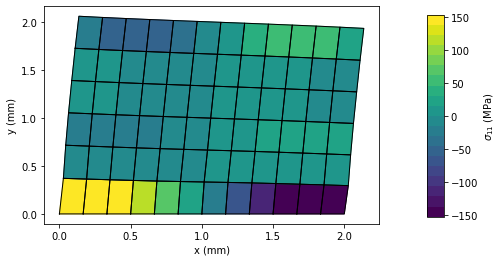

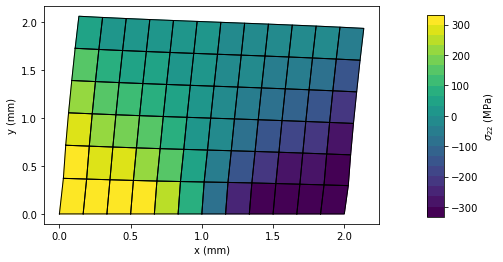

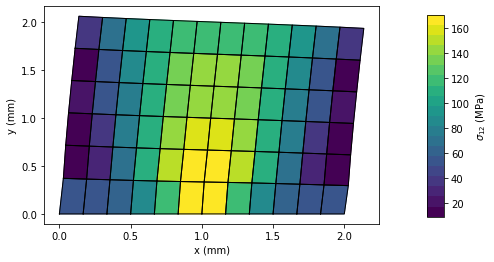

In [3]:
# setup plane stress finite element model for mat1 under simple shear with force controlled BC
fem=FE.Model(dim=2,planestress=True)  # generate instance of class Model
fem.geom([2], LY=2.)  # define geometry
print('====================================================')
print('=== FEA of simple shear with force controlled BC ===')
print('====================================================')
fem.assign([mat1])  # assigne material to geometry
fem.bcbot(0., bctype='disp', bcdir='y')  # fixed BC at bottom of model
fem.bcbot(0., bctype='disp', bcdir='x')
fem.bcleft(0., bctype='force')  # free BC at left and right hand sides
fem.bcright(0., bctype='force')
fem.bctop(180., bctype='force', bcdir='x')  # apply shear force at top nodes
fem.bctop(0., bctype='force', bcdir='y')
fem.mesh(NX=12, NY=6)  # generate structured mesh
fem.solve(verb=False)
fem.calc_global()  # evaluate global quantities at end of load step
ne1 = 33  # number of "red" element in lecture slide
ne2 = 60  # number of "blue" element in lecture slide
print('Materials: ref={}, ML={}'.format(fem.element[ne1].Mat.name, fem.element[ne2].Mat.name))
print('Global strain: ', np.round(fem.glob['eps'], decimals=4))
print('Element strain (red): ', np.round(fem.element[ne1].eps, decimals=4))
print('Element strain (blue): ', np.round(fem.element[ne2].eps, decimals=4))
print('Global stress: ', np.round(fem.glob['sig'], decimals=3))
print('Element stress (red): ', np.round(fem.element[ne1].sig, decimals=3))
print('Element stress (blue): ', np.round(fem.element[ne2].sig, decimals=3))
print('Global plastic strain: ', np.round(fem.glob['epl'], decimals=5))
print('Plastic strain (red): ', np.round(fem.element[ne1].epl, decimals=5))
print('Plastic strain (blue): ', np.round(fem.element[ne2].epl, decimals=5))

fem.plot('stress1',mag=10,shownodes=False)
fem.plot('stress2',mag=10,shownodes=False)
fem.plot('stress12',mag=10,shownodes=False)

## 3. Evaluation of equivalent stresses

The J2 equivalent stresses and the equivalent plastic strains are plotted for each finite element. Since the material model follows the J2 equivalent stress to calculate the plastic flow behavior of the material, it is seen that plastic yielding occurs only in elements in which the critical equivalent stress - matching the uniaxial yield strength of the material - is reached. Furthermore, it is seen that this critical value of the equivalent stress in never exceeded, in agreement to the assumption of ideal plasticity, in which no work hardening occurs such that the flow stress in the material is bounded by the value of the yield strength.

The J2 equivalent stress is defined as

\begin{equation} 
\sigma^\mathrm{J2}_{eq} = \sqrt{ \frac{1}{2}\left[ \left(\sigma_1-\sigma_2\right)^2 
                       +  \left(\sigma_2-\sigma_3\right)^2 
                       +  \left(\sigma_3-\sigma_1\right)^2   \right] } ,
\end{equation}

which - in this formulation - is based on the pricipal stresses $\sigma_i$ with $i=1, 2, 3$. 

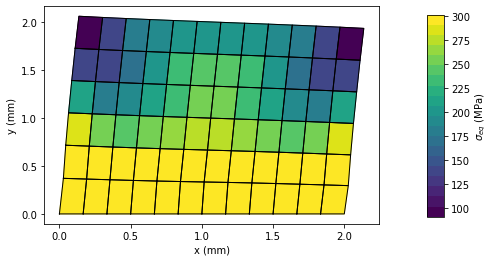

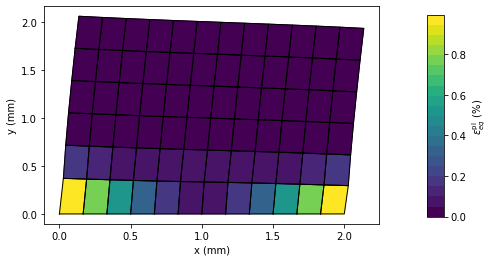

In [4]:
fem.plot('seq',mag=10,shownodes=False)
fem.plot('peeq',mag=10,shownodes=False)

## 4. Comparison of local stresses with critical equivalent stress

The principal stresses of the stress tensor in each element are calculated and plotted in the principle stress space such that each element corresponds to one data point in stress space. It is seen, that the data points for all elements reaching the yield criterion form a convex hull of all stress states in the model. This bounding line is called the yield locus of the material. Every stress state lying on this yield locus has the same value for the equivalent stress, corresponding to the uniaxial yield strength of the material.

In the plot, the definitions of equivalent stresses after von Mises (J2 equivalent stress) and after Tresca are compared. The Tresca equivalent stress is also based on the pricipal stresses $\sigma_\mathrm{I} \ge \sigma_\mathrm{II} \ge \sigma_\mathrm{III}$, and defined as

\begin{equation} 
\sigma^\mathrm{Tresca}_{eq} = \frac{\sigma_\mathrm{I} - \sigma_\mathrm{III}}{2} .
\end{equation}

It is seen that a yield criterion after the Tresca equivalent stress is more conservative, i.e. it would predict plastic yielding already at smaller stress values. However, for this material model, as for most application of FEA, the plastic behavior is evaluated according to the von Mises (J2) equivalent stress.

<Figure size 432x288 with 0 Axes>

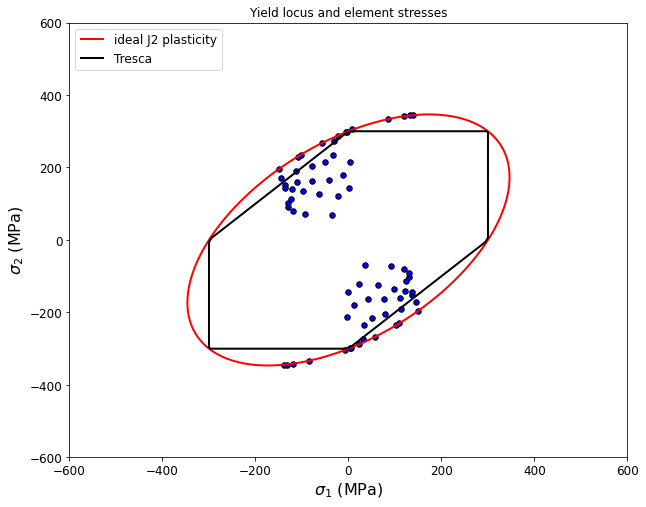

In [5]:
# plot priciple stress in each element, together with the yield locus of the material
#Tresca-material as comparison
mat_t = FE.Material(name='Tresca')
mat_t.elasticity(E=E, nu=nu)
mat_t.plasticity(sy=sy, tresca=True)

ax = mat1.plot_yield_locus(ref_mat=mat_t, scaling=False)
for el in fem.element:
    sp = FE.Stress(el.sig).p  # get principle stress of each element
    ax.scatter(sp[0], sp[1], s=30, c='b', edgecolors='k')
ax.set_title('Yield locus and element stresses')
plt.show()

## 5. Exercises
- Create materials with different initial strengths and compare the results of the FE model. Note that for force controlled BC you will need to adapt the value of the shear force applied at the top boundary of the model.
- Create materials with identical plastic properties but different elastic constants and compare the results of the FEA.
- Create boundary conditions for uniaxial and equi-biaxial load cases and compare the results.